## 1. 데이터 로드 (CIFAR-10)

In [48]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def get_dataloader(batch_size=128, num_workers=4, pin_memory=True):
    """
    CIFAR-10 데이터 로드 함수. 데이터 전처리와 최적화를 포함.

    Args:
        batch_size (int): 배치 크기
        num_workers (int): DataLoader의 워커 수
        pin_memory (bool): GPU로 빠르게 전송을 위해 고정 메모리 사용 여부

    Returns:
        train_loader, test_loader
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize RGB channels
    ])

    # CIFAR-10 데이터셋 로드
    train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform)

    # DataLoader
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory
    )
    return train_loader, test_loader

## 2. 모델 정의 (CIFAR-10을 위한 모델)

In [49]:
# from torchvision import models
from torchvision.models.quantization import resnet18
from torchvision.models import ResNet18_Weights
import torch.nn as nn

def get_resnet_for_cifar10():
    """
    ResNet-18 모델을 CIFAR-10에 맞게 수정
    Returns:
        모델 객체
    """
    model = resnet18(weights=None)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)  # CIFAR-10 크기에 맞게 수정
    model.maxpool = nn.Identity()  # 첫 번째 MaxPooling 제거
    model.fc = nn.Linear(model.fc.in_features, 10)  # CIFAR-10 클래스 수에 맞게 출력 수정
    return model

## 3. 학습 및 평가 함수

In [50]:
import torch
import time
import os

def train(model, dataloader, criterion, optimizer, device="cpu"):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = running_loss / total
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def evaluate(model, dataloader, criterion, device="cpu"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / total
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, device, epochs, best_model_path):
    """모델 학습 및 검증 과정"""
    best_val_acc = 0.0

    # 실시간 시각화 초기화
    live_plot = LivePlot()

    for epoch in range(epochs):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, test_loader, criterion, device)

        # 실시간 시각화 업데이트 (live_plot 객체 필요 시 활성화)
        live_plot.update(epoch, train_loss, train_acc, val_loss, val_acc)

        print(f"Epoch {epoch + 1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.2f}%, Val Loss={val_loss:.4f}, Val Acc={val_acc:.2f}%")

        # 최적의 모델 저장
        if val_acc > best_val_acc:
            print(f"New best model found at epoch {epoch + 1} with Val Acc={val_acc:.2f}%")
            best_val_acc = val_acc
            save_checkpoint(model, filepath=best_model_path)

    return best_val_acc

# 모델 학습 결과 저장
def save_results(results, filepath="results.json"):
    import json
    with open(filepath, "w") as f:
        json.dump(results, f, indent=4)

# 추론 속도 측정 함수
def measure_inference_speed(model, dataloader, device, num_batches=256):
    model.eval()
    total_time = 0.0
    with torch.no_grad():
        for images, labels in dataloader:
            if len(images) < num_batches:
                break
            images = images.to(device)
            start_time = time.time()
            _ = model(images)
            total_time += time.time() - start_time
    avg_time = total_time / num_batches
    return avg_time

def model_size(model, path="temp.pth"):
    torch.save(model.state_dict(), path)
    size_mb = os.path.getsize(path) / 1e6
    os.remove(path)
    return size_mb

In [51]:
import torch

def save_checkpoint(model, filepath="best_model.pth"):
    """현재 모델 상태를 저장"""
    torch.save(model.state_dict(), filepath)

def load_checkpoint(model, filepath="best_model.pth"):
    """저장된 모델 상태를 불러오기"""
    model.load_state_dict(torch.load(filepath))
    return model

## 4. 학습 과정 시각화

In [52]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

class LivePlot:
    def __init__(self):
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []

    def update(self, epoch, train_loss, train_acc, val_loss, val_acc):
        self.train_loss.append(train_loss)
        self.val_loss.append(val_loss)
        self.train_acc.append(train_acc)
        self.val_acc.append(val_acc)

        # Colab에서는 출력 초기화 후 새로 그리기
        clear_output(wait=True)
        plt.figure(figsize=(12, 5))

        # Loss 그래프
        plt.subplot(1, 2, 1)
        plt.plot(self.train_loss, label='Train Loss', color='blue')
        plt.plot(self.val_loss, label='Validation Loss', color='orange')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss")
        plt.legend()

        # Accuracy 그래프
        plt.subplot(1, 2, 2)
        plt.plot(self.train_acc, label='Train Accuracy', color='green')
        plt.plot(self.val_acc, label='Validation Accuracy', color='red')
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy (%)")
        plt.title("Training and Validation Accuracy")
        plt.legend()

        plt.show()

## 5. QAT, PTQ

In [53]:
import torch
import torch.quantization as quant
from torch.ao.quantization.observer import MinMaxObserver, PerChannelMinMaxObserver
from torch.ao.quantization import MinMaxObserver, FakeQuantize

class FourBitObserver(MinMaxObserver):
    def __init__(self, *args, **kwargs):
        super(FourBitObserver, self).__init__(*args, **kwargs)
        self.quant_min = 0  # 최소값
        self.quant_max = 15  # 4-bit 최대값 (2^4 - 1)

    def calculate_qparams(self):
        # 4-bit 범위에서 스케일 및 zero-point 계산
        scale, zero_point = super().calculate_qparams()
        return scale, zero_point.clamp(self.quant_min, self.quant_max)

# 4-bit FakeQuantization 모듈
class FourBitFakeQuantize(FakeQuantize):
    def __init__(self, *args, **kwargs):
        observer = FourBitObserver.with_args(dtype=torch.quint8)
        super(FourBitFakeQuantize, self).__init__(observer=observer, *args, **kwargs)

# PTQ 수행
def apply_ptq(model, train_loader, test_loader, criterion, optimizer, device, epochs=10, best_model_path="best_ptq_model.pth"):
    """Post-Training Quantization 수행"""
    print("Applying PTQ...")
    # 모델 학습 및 초기 성능 최적화
    post_acc = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, device, epochs, best_model_path)

    # Quantization 준비
    model.qconfig = torch.quantization.get_default_qconfig("fbgemm")

    # Observer 설정 - 8bit
    model.qconfig = quant.QConfig(
        activation=quant.MinMaxObserver.with_args(qscheme=torch.per_tensor_affine),
        weight=quant.MinMaxObserver.with_args(dtype=torch.qint8, qscheme=torch.per_tensor_affine)
    )

    # Prepare 단계
    print("Preparing model for quantization...")
    torch.quantization.prepare(model, inplace=True)


    # Calibration 단계
    print("Calibrating model...")
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            model(inputs)
            break

    post_ptq_size = model_size(model)
    print(f"Post-PTQ Model Size: {post_ptq_size} MB")


    # Quantization 변환
    model.to("cpu")
    model.eval()
    quant.convert(model, inplace=True)

    post_ptq_inf_time = measure_inference_speed(model, test_loader, "cpu")
    print(f"Post-PTQ Inference Time: {post_ptq_inf_time} seconds")

    # 최종 성능 평가
    acc = evaluate(model, test_loader, criterion, "cpu")[1]
    print(f"PTQ Model Accuracy: {acc:.2f}%")
    return model, acc, post_acc, post_ptq_size, post_ptq_inf_time

# QAT 수행
def apply_qat(model, train_loader, test_loader, criterion, optimizer, device, epochs=10, best_model_path="best_qat_model.pth"):
    """Quantization Aware Training 수행"""
    print("Applying QAT...")

    # QAT 준비
    model.train()
    model.qconfig = quant.get_default_qat_qconfig("fbgemm")

    # Observer 설정 - 8bit
    model.qconfig = quant.QConfig(
        activation=quant.MinMaxObserver.with_args(qscheme=torch.per_tensor_affine),
        weight=quant.MinMaxObserver.with_args(dtype=torch.qint8, qscheme=torch.per_tensor_affine)
    )
    quant.prepare_qat(model, inplace=True)

    # 학습 및 최적화
    post_acc = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, device, epochs, best_model_path)

    post_qat_size = model_size(model)
    print(f"Post-QAT Model Size: {post_qat_size} MB")


    # Quantization 변환
    model.to("cpu")
    model.eval()  # 평가 모드로 전환
    quant.convert(model, inplace=True)  # 양자화된 연산자로 변환

    post_qat_inf_time = measure_inference_speed(model, test_loader, "cpu")
    print(f"Post-QAT Inference Time: {post_qat_inf_time} seconds")

    # 최종 성능 평가
    acc = evaluate(model, test_loader, criterion, "cpu")[1]
    print(f"QAT Model Accuracy: {acc:.2f}%")
    return model, acc, post_acc, post_qat_size, post_qat_inf_time

# PTQ와 QAT 비교 함수
def compare_ptq_qat(_ptq_model, _qat_model, train_loader, test_loader, criterion, ptq_optimizer, qat_optimizer, device, epochs=10):
    print("\n=== Running PTQ ===")
    ptq_model = _ptq_model  # Copy baseline model
    ptq_model, ptq_acc, post_ptq_acc, post_ptq_size, post_ptq_inf_time = apply_ptq(
        ptq_model, train_loader, test_loader, criterion, ptq_optimizer, device, epochs
    )
    ptq_size = model_size(ptq_model)
    ptq_inference_time = measure_inference_speed(ptq_model, test_loader, "cpu")

    print("\n=== Running QAT ===")
    qat_model = _qat_model
    qat_model, qat_acc, post_qat_acc, post_qat_size, post_qat_inf_time = apply_qat(
        qat_model, train_loader, test_loader, criterion, qat_optimizer, device, epochs
    )
    qat_size = model_size(qat_model)
    qat_inference_time = measure_inference_speed(qat_model, test_loader, "cpu")

    # 비교 결과 출력
    print("\n=== Results ===")
    results = {
        "PTQ": {
            "Accuracy": ptq_acc,
            "Model Size (MB)": ptq_size,
            "Inference Time (s)": ptq_inference_time,
            "Post-PTQ Accuracy": post_ptq_acc,
            "Post-PTQ Model Size (MB)": post_ptq_size,
            "Post-PTQ Inference Time (s)": post_ptq_inf_time,
        },
        "QAT": {
            "Accuracy": qat_acc,
            "Model Size (MB)": qat_size,
            "Inference Time (s)": qat_inference_time,
            "Post-QAT Accuracy": post_qat_acc,
            "Post-QAT Model Size (MB)": post_qat_size,
            "Post-QAT Inference Time (s)": post_qat_inf_time,
        },
    }
    save_results(results, filepath="ptq_qat_results.json")
    print(results)
    return results

## 5. Main Workflow

### 5-1. 모델 학습

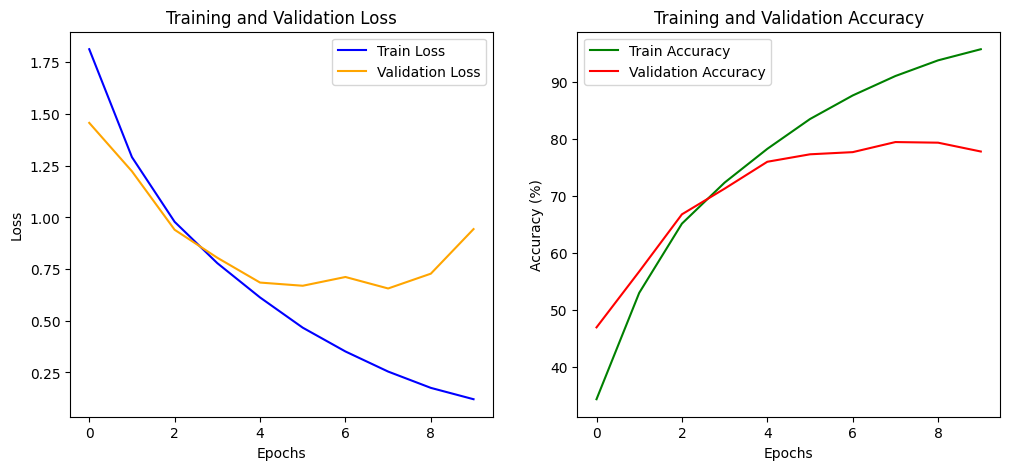

Epoch 10: Train Loss=0.1206, Train Acc=95.78%, Val Loss=0.9435, Val Acc=77.82%
Post-QAT Model Size: 44.839835 MB
Post-QAT Inference Time: 0.36036838311702013 seconds
QAT Model Accuracy: 69.12%

=== Results ===
{'PTQ': {'Accuracy': 81.3, 'Model Size (MB)': 11.303568, 'Inference Time (s)': 0.3581616338342428, 'Post-PTQ Accuracy': 81.69, 'Post-PTQ Model Size (MB)': 44.818966, 'Post-PTQ Inference Time (s)': 0.363964363001287}, 'QAT': {'Accuracy': 69.12, 'Model Size (MB)': 11.303632, 'Inference Time (s)': 0.35371402371674776, 'Post-QAT Accuracy': 79.48, 'Post-QAT Model Size (MB)': 44.839835, 'Post-QAT Inference Time (s)': 0.36036838311702013}}


In [54]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 로드
batch_size = 256  # 최적 배치 크기
num_workers = 2  # 시스템의 CPU 코어 수에 맞게 조정
pin_memory = False  # GPU 사용 시 활성화

train_loader, test_loader = get_dataloader(
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=pin_memory
)

# 모델 초기화
ptq_model = get_resnet_for_cifar10().to(device)  # New instance for QAT
qat_model = get_resnet_for_cifar10().to(device)
criterion = torch.nn.CrossEntropyLoss()
ptq_optimizer = torch.optim.Adam(ptq_model.parameters(), lr=0.01)
qat_optimizer = torch.optim.Adam(qat_model.parameters(), lr=0.01)


# PTQ와 QAT 비교
results = compare_ptq_qat(ptq_model, qat_model, train_loader, test_loader, criterion, ptq_optimizer, qat_optimizer,device, epochs=10)

In [55]:
print("===Results===")
for method, metrics in results.items():
        print(f"{method} - Accuracy: {metrics['Accuracy']}%, Size: {metrics['Model Size (MB)']} MB, Inference Time: {metrics['Inference Time (s)']:.4f} s")
        print(f"{method} - Post-PTQ Accuracy: {metrics['Post-'+method+' Accuracy']}%, Size: {metrics['Post-'+method+' Model Size (MB)']} MB, Inference Time: {metrics['Post-'+method+' Inference Time (s)']:.4f} s")

===Results===
PTQ - Accuracy: 81.3%, Size: 11.303568 MB, Inference Time: 0.3582 s
PTQ - Post-PTQ Accuracy: 81.69%, Size: 44.818966 MB, Inference Time: 0.3640 s
QAT - Accuracy: 69.12%, Size: 11.303632 MB, Inference Time: 0.3537 s
QAT - Post-PTQ Accuracy: 79.48%, Size: 44.839835 MB, Inference Time: 0.3604 s
